# Exploration 6 - 영화리뷰 텍스트 감성분석하기

# EX_06 목표
## 딥러닝을 통해 텍스트에 담긴 감성을 분석(Sentimental Analysis)하는 방법을 배워보기

- 구체적으로 IMDb나 네이버 영화 리뷰 텍스트에 담긴 이용자의 감성이 긍정적인지 혹은 부정적인지를 분류할 수 있는 딥러닝 모델을 만들어보기
-RNN(LSTM) 모델로 데이터 학습 및 테스트해보기

## 학습목표
- 텍스트 데이터를 머신러닝 입출력용 수치데이터로 변환하는 과정을 이해한다
- RNN의 특징을 이해하고 시퀀셜한 데이터를 다루는 방법을 이해한다
- 1-D CNN으로도 텍스트를 처리할 수 있음을 이해한다
- IMDB와 네이버 영화리뷰 데이터셋을 이용한 영화리뷰 감성 분류 실습을 진행한다

# 시퀀스 데이터를 다루는 RNN

- 시퀀스 데이터를 다루는데 유용하다 (이미지는 시퀀스 데이터가 아니다)
- 새롭게 들어오는 입력에 따라 변하는 현재 상태를 묘사하는 state machine으로 설계되었다

---------------
들어가기에 앞서 인코더 디코더 함수 살펴보기

In [ ]:
# 여러 개의 문장 리스트를 한꺼번에 숫자 텐서로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# sentences=['i feel hungry', 'i eat lunch', 'now i feel happy'] 가 아래와 같이 변환됩니다. 
encoded_sentences = get_encoded_sentences(sentences, word_to_index)
print(encoded_sentences)

In [ ]:
# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# encoded_sentences=[[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]] 가 아래와 같이 변환됩니다.
print(get_decoded_sentences(encoded_sentences, index_to_word))

In [ ]:
# 필요한 라이브러리 불러오기

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os

from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split

from konlpy.tag import Mecab
from collections import Counter
import gensim

## 데이터 준비

In [ ]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

print(train_data.shape, test_data.shape)
train_data.head()

(150000, 3) (50000, 3)


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


총 200,000 개의 영화 리뷰가 존재한다는 것을 알 수 있다. 1은 긍정, 0은 부정을 뜻한다.

## 데이터로더 구성

데이터 로더 :

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴


In [ ]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    
    train_data.drop_duplicates(subset=['document'], inplace=True) # 중복 데이터 제거
    train_data = train_data.dropna(how = 'any')                   # 결측치 제거
    # test_data 에 동일한 작업 반복
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    # Tokenize
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4)  # 가장 많이 사용되는 num_words-4 개의 단어 추출 (4 단어는 예약되어 있다)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]  # 맨 앞 4 인덱스는 특수한 용어로 할당
    word_to_index = {word:index for index, word in enumerate(vocab)}  # 어휘 사전 구성
        
    # word to index
    def wordlist_to_indexlist(wordlist):
        return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [ ]:
len(X_train), len(X_test)

(146182, 49157)

In [ ]:
index_to_word = {index:word for word, index in word_to_index.items()}
print(len(index_to_word))
index_to_word

10000


{0: '<PAD>',
 1: '<BOS>',
 2: '<UNK>',
 3: '<UNUSED>',
 4: '.',
 5: '영화',
 6: '다',
 7: '고',
 8: '하',
 9: '을',
 10: '보',
 11: '..',
 12: '게',
 13: ',',
 14: '!',
 15: '지',
 16: '있',
 17: '없',
 18: '?',
 19: '좋',
 20: '나',
 21: '었',
 22: '만',
 23: '는데',
 24: '너무',
 25: '봤',
 26: '적',
 27: '안',
 28: '정말',
 29: '로',
 30: '음',
 31: '것',
 32: '아',
 33: '네요',
 34: '재밌',
 35: '어',
 36: '같',
 37: '점',
 38: '지만',
 39: '진짜',
 40: '했',
 41: '에서',
 42: '기',
 43: '네',
 44: '않',
 45: '거',
 46: '았',
 47: '수',
 48: '되',
 49: '면',
 50: 'ㅋㅋ',
 51: '말',
 52: '연기',
 53: '인',
 54: '주',
 55: '내',
 56: '최고',
 57: '~',
 58: '평점',
 59: '이런',
 60: '던',
 61: '어요',
 62: '할',
 63: '왜',
 64: '겠',
 65: '1',
 66: '스토리',
 67: '해',
 68: '습니다',
 69: 'ㅋㅋㅋ',
 70: '...',
 71: '드라마',
 72: '생각',
 73: '아니',
 74: '더',
 75: '그',
 76: '싶',
 77: '사람',
 78: '듯',
 79: '때',
 80: '감동',
 81: '함',
 82: '배우',
 83: '본',
 84: '까지',
 85: '뭐',
 86: '알',
 87: '만들',
 88: '내용',
 89: '볼',
 90: '감독',
 91: '보다',
 92: '라',
 93: '그냥',
 94: '재미',
 95

In [ ]:
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

아 더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


디코딩하는 함수들을 정의하여 문장들이 제대로 인코딩 되었다는 것을 확인하였다. train_data[0]의 내용과 일치한다.

## 모델 구성을 위한 데이터 분석 및 가공

### RNN을 사용하면서 주의해야할 점

- Embedding 레이어의 인풋이 되는 문장 벡터는 그 길이가 일정해야 한다
- Tensorflow에서는 문장 벡터 뒤에 패딩(<PAD>}을 추가하여 길이를 일정하게 맞춰주는 기능을 제공한다

(1) 데이터셋 내 문장 길이 분포

In [ ]:
total_data_text = list(X_train) + list(X_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  16.96940191154864
문장길이 최대 :  117
문장길이 표준편차 :  12.843571191092


### (2) 적절한 최대 문장 길이 지정

In [ ]:
# 기준: 평균 + (2 * 표준편차)
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  42
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


임의로 문장의 길이를 결정한 것인데, 대부분의 문장들(전체 문장의 93%)이 이 길이 이내에 있기 때문에 이대로 이용하겠다. 

### (3) 패딩 추가

In [ ]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train.shape, X_test.shape)

(146182, 42) (49157, 42)


RNN 모델에서는 입력의 마지막이 가장 큰 영향을 미치기 때문에 패딩을 뒤가 아닌 앞에 배치하기 위해 __'pre'__ 로 설정한다. 

## 모델 구성 및 validation set 구성

### Train, Validation set으로 분리

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [ ]:
print(X_train.shape, X_val.shape)

(116945, 42) (29237, 42)


### (1) LSTM 모델 (RNN)

In [ ]:
vocab_size = 10000    # 어휘 사전의 단어 수 
word_vector_dim = 16  # 워드 벡터의 차원 수 

model_LSTM = tf.keras.Sequential()
model_LSTM.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_LSTM.add(tf.keras.layers.LSTM(32))   
model_LSTM.add(tf.keras.layers.Dense(16, activation='relu'))
model_LSTM.add(tf.keras.layers.Dense(1, activation='sigmoid')) 


model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                6272      
_________________________________________________________________
dense (Dense)                (None, 16)                528       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 166,817
Trainable params: 166,817
Non-trainable params: 0
_________________________________________________________________


### (2) CNN 모델

In [ ]:
vocab_size = 10000 
word_vector_dim = 16  

model_CNN = tf.keras.Sequential()
model_CNN.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_CNN.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_CNN.add(tf.keras.layers.MaxPooling1D(5))
model_CNN.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_CNN.add(tf.keras.layers.GlobalMaxPooling1D())
model_CNN.add(tf.keras.layers.Dense(8, activation='relu'))
model_CNN.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model_CNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

### (3) GlobalMaxPooling1D 모델

In [ ]:
vocab_size = 10000  
word_vector_dim = 16  

model_GMP = tf.keras.Sequential()
model_GMP.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_GMP.add(tf.keras.layers.GlobalMaxPooling1D())
model_GMP.add(tf.keras.layers.Dense(8, activation='relu'))
model_GMP.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_GMP.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


## 모델 훈련 개시

### (1) LSTM 모델 훈련

In [ ]:
model_LSTM.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  

history_LSTM = model_LSTM.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
229/229 [==============================] - 5s 8ms/step - loss: 0.4668 - accuracy: 0.7751 - val_loss: 0.3635 - val_accuracy: 0.8436
Epoch 2/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3344 - accuracy: 0.8580 - val_loss: 0.3517 - val_accuracy: 0.8476
Epoch 3/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3156 - accuracy: 0.8674 - val_loss: 0.3535 - val_accuracy: 0.8480
Epoch 4/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3030 - accuracy: 0.8740 - val_loss: 0.3531 - val_accuracy: 0.8478
Epoch 5/20
229/229 [==============================] - 1s 6ms/step - loss: 0.2917 - accuracy: 0.8788 - val_loss: 0.3512 - val_accuracy: 0.8487
Epoch 6/20
229/229 [==============================] - 1s 6ms/step - loss: 0.2800 - accuracy: 0.8846 - val_loss: 0.3505 - val_accuracy: 0.8493
Epoch 7/20
229/229 [==============================] - 1s 6ms/step - loss: 0.2662 - accuracy: 0.8905 - val_loss: 0.3695 - val_accuracy: 0.8475
Epoch 

In [ ]:
results_LSTM = model_LSTM.evaluate(X_test,  y_test, verbose=2)

print(results_LSTM)

1537/1537 - 3s - loss: 0.6644 - accuracy: 0.8322
[0.6643595099449158, 0.8321500420570374]


### (2) CNN 모델 훈련

In [ ]:
model_CNN.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  

history_CNN = model_CNN.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
229/229 [==============================] - 3s 6ms/step - loss: 0.5192 - accuracy: 0.7356 - val_loss: 0.3775 - val_accuracy: 0.8336
Epoch 2/20
229/229 [==============================] - 1s 5ms/step - loss: 0.3416 - accuracy: 0.8514 - val_loss: 0.3559 - val_accuracy: 0.8435
Epoch 3/20
229/229 [==============================] - 1s 5ms/step - loss: 0.3063 - accuracy: 0.8698 - val_loss: 0.3530 - val_accuracy: 0.8456
Epoch 4/20
229/229 [==============================] - 1s 5ms/step - loss: 0.2784 - accuracy: 0.8851 - val_loss: 0.3563 - val_accuracy: 0.8433
Epoch 5/20
229/229 [==============================] - 1s 5ms/step - loss: 0.2493 - accuracy: 0.8996 - val_loss: 0.3721 - val_accuracy: 0.8445
Epoch 6/20
229/229 [==============================] - 1s 5ms/step - loss: 0.2189 - accuracy: 0.9144 - val_loss: 0.3993 - val_accuracy: 0.8361
Epoch 7/20
229/229 [==============================] - 1s 5ms/step - loss: 0.1885 - accuracy: 0.9286 - val_loss: 0.4239 - val_accuracy: 0.8356
Epoch 

In [ ]:
results_CNN = model_CNN.evaluate(X_test,  y_test, verbose=2)

print(results_CNN)

1537/1537 - 2s - loss: 0.9404 - accuracy: 0.8074
[0.9404298067092896, 0.8073519468307495]


### (3) GlobalMaxPooling 모델 훈련

In [ ]:
model_GMP.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20 

history_GMP = model_GMP.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
229/229 [==============================] - 1s 4ms/step - loss: 0.6197 - accuracy: 0.7290 - val_loss: 0.4819 - val_accuracy: 0.8111
Epoch 2/20
229/229 [==============================] - 1s 4ms/step - loss: 0.4008 - accuracy: 0.8309 - val_loss: 0.3760 - val_accuracy: 0.8363
Epoch 3/20
229/229 [==============================] - 1s 4ms/step - loss: 0.3403 - accuracy: 0.8540 - val_loss: 0.3615 - val_accuracy: 0.8406
Epoch 4/20
229/229 [==============================] - 1s 4ms/step - loss: 0.3120 - accuracy: 0.8690 - val_loss: 0.3574 - val_accuracy: 0.8434
Epoch 5/20
229/229 [==============================] - 1s 4ms/step - loss: 0.2916 - accuracy: 0.8785 - val_loss: 0.3591 - val_accuracy: 0.8437
Epoch 6/20
229/229 [==============================] - 1s 4ms/step - loss: 0.2752 - accuracy: 0.8870 - val_loss: 0.3641 - val_accuracy: 0.8433
Epoch 7/20
229/229 [==============================] - 1s 4ms/step - loss: 0.2615 - accuracy: 0.8934 - val_loss: 0.3701 - val_accuracy: 0.8429
Epoch 

In [ ]:
results_GMP = model_GMP.evaluate(X_test,  y_test, verbose=2)

print(results_GMP)

1537/1537 - 2s - loss: 0.4956 - accuracy: 0.8266
[0.49560293555259705, 0.8266167640686035]


## Loss, Accuracy 그래프 시각화

In [ ]:
def acc_loss_plot(hist):
    epochs = range(1, 21)
    
    fit, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()
    
    loss_ax.plot(epochs, hist.history["loss"], "y", label="train_loss")
    loss_ax.plot(epochs, hist.history["val_loss"], "r", label="val_loss")
    loss_ax.set_xlabel("Epoch")
    loss_ax.set_xticks(range(1,21))
    loss_ax.set_ylabel("Loss")
    loss_ax.legend(loc = "upper left")
    
    acc_ax.plot(epochs, hist.history["accuracy"], "b", label="train_acc")
    acc_ax.plot(epochs, hist.history["val_accuracy"], "g", label="val_acc")
    acc_ax.set_ylabel("Accuracy")
    acc_ax.legend(loc = "upper right")
    
    plt.show()

### (1) LSTM 모델 Loss, Accuracy 그래프

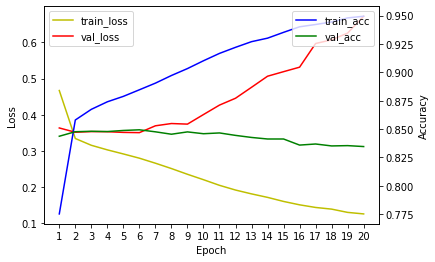

In [ ]:
acc_loss_plot(history_LSTM)

### (2) CNN 모델 Loss, Accuracy 그래프

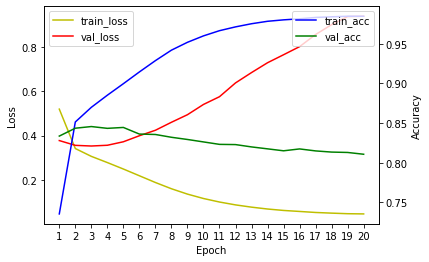

In [ ]:
acc_loss_plot(history_CNN)

### (3) GlobalMaxPooling 모델 Loss, Accuracy 그래프

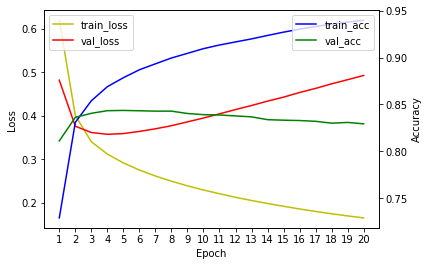

In [ ]:
acc_loss_plot(history_GMP)

세 모델 모두 굉장히 빨리 학습이 되어 오버피팅이 되기 시작한다는 것을 알 수 있다. Validation Accuracy, Validation Loss 모두 3 번째 epoch 쯤에서 꺾이기 시작하는데, 이쯤에서 학습을 멈추면 성능이 가장 잘 나올 것이라고 예상이 가능하다. 다시 모델을 학습시킨다면 epoch의 수를 줄이거나 ModelCheckpoint와 같은 callback함수를 적절하게 사용하여 성능을 높일 수 있다. 

## 학습된 Embedding 레이어 분석

LSTM 모델의 Embedding 레이어를 분석해보겠다. gensim을 이용하여 워드 벡터들이 어떤 유의미한 형태로 학습이 되었는지 살펴보자. 

In [ ]:
embedding_layer = model_LSTM.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [ ]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_ex.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_LSTM.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [ ]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

array([-0.00440809,  0.00057352,  0.02813615, -0.07664039,  0.04096609,
       -0.00408349,  0.03957812,  0.01881017,  0.02793296, -0.02631269,
       -0.03158625, -0.04692183, -0.07689742,  0.01768068, -0.01549166,
        0.03751905], dtype=float32)

'영화'라는 단어가 16차원의 벡터로 저장이 되었다는 것을 볼 수 있다. gensim의 similar_by_word를 이용하면 다음과 같이 유사한 단어와 그 유사도를 확인할 수 있다. 

In [ ]:
word_vectors.similar_by_word("영화")

[('점', 0.7855023145675659),
 ('음', 0.7784633636474609),
 ('확실', 0.731606662273407),
 ('b', 0.7018688917160034),
 ('미드', 0.6735660433769226),
 ('봄', 0.6610224843025208),
 ('드라마', 0.6551343202590942),
 ('~~', 0.6536486148834229),
 ('죽', 0.649878978729248),
 ('준다', 0.649491548538208)]

나온 단어들이 '영화'와 그다지 유사하지 않다 것을 확인 할 수 있는데, 아무래도 우리가 학습한 데이터셋의 크기는 워낙 작기 때문이다. 사전 학습이 완료된 임베딩 모델은 훨씬 높은 성능을 기대할 수 있는데, 박규병님의 한국어 Word2Vec을 가져와서 비교를 해보겠다. 

### 한국어 Word2Vec과 비교

In [ ]:
#pip install gensim==3.8.3

In [ ]:
# 한국어 Word2Vec 불러오기 
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec.wv['영화']
vector     #  한국어 Word2Vec의 벡터는 크기가 200이다. 

array([-1.7577837 , -1.0874279 ,  1.5300866 , -0.1115231 , -0.37980682,
        1.4828517 ,  1.3180419 ,  0.11094163,  0.7430535 , -0.45461136,
        0.58841336,  0.5763913 ,  1.210707  ,  1.3132795 , -0.86962503,
       -0.18507595, -0.47440064,  1.5100725 ,  1.0965794 ,  1.0600823 ,
       -0.27457932, -0.70003706,  2.3117511 ,  1.4944884 ,  0.25560892,
       -2.866659  , -0.28312334,  0.34263936, -0.67723423,  0.71714777,
        0.25549442,  0.71732044, -0.13262457,  0.01792452, -0.3184774 ,
        0.5271619 ,  0.7561084 , -2.1247065 ,  1.061429  , -0.21065854,
        0.6877343 , -1.4956383 ,  0.60346967, -2.6955893 ,  0.37694618,
       -1.0164185 ,  0.5430663 ,  0.1200121 , -2.6315718 ,  0.6216742 ,
        1.1583976 , -2.5385962 ,  1.326312  , -0.10284371, -0.0286147 ,
       -0.9132947 ,  0.7647564 ,  0.79202783, -1.8625957 , -0.7418395 ,
        0.5884277 , -0.9917992 , -0.62114453,  1.5367815 , -0.6628939 ,
        0.6712103 ,  0.12914915,  0.21228492,  0.9017655 , -0.25

우리가 학습한 워드 벡터의 차원은 16인 반면에, 한국어 Word2Vec의 벡터의 크기는 200이나 된다. 

In [ ]:
word2vec.wv.similar_by_word("영화")

[('다큐멘터리', 0.7265259027481079),
 ('영화사', 0.715214192867279),
 ('드라마', 0.705294132232666),
 ('뮤지컬', 0.6947016716003418),
 ('코미디', 0.69093257188797),
 ('영화인', 0.6702202558517456),
 ('서부극', 0.6571458578109741),
 ('스릴러', 0.6533164978027344),
 ('로맨스', 0.6428799629211426),
 ('애니메이션', 0.6425570249557495)]

역시나 학습이 잘 되었기 때문에, 이전보다 더 '영화'와 유사한 단어들이 나오는 것을 확인할 수 있다. 

## 한국어 Word2Vec 임베딩 활용하여 성능 개선

가져온 한국어 Word2Vec이 학습이 더 잘 되어 있다는 것을 확인했으니, 이전에 학습한 모델의 임베딩 레이어만 교체하여 다시 학습 시켜보겠다. 성능을 비교해보자. 

In [ ]:
vocab_size = 10000    # 어휘 사전의 크기 (10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[index_to_word[i]]

### LSTM 모델의 Embedding 레이어 교체

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
# 여기는 동일
model.add(tf.keras.layers.LSTM(32))  
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  


model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 42, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                29824     
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 2,030,369
Trainable params: 2,030,369
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 이 callback 함수를 이용하여 val_loss가 가장 작은 모델을 저장한다. 
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

epochs=20 

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    callbacks = [checkpoint],
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
229/229 [==============================] - 3s 9ms/step - loss: 0.4863 - accuracy: 0.7583 - val_loss: 0.3802 - val_accuracy: 0.8332

Epoch 00001: val_loss improved from inf to 0.38017, saving model to best_model.h5
Epoch 2/20
229/229 [==============================] - 2s 8ms/step - loss: 0.3472 - accuracy: 0.8495 - val_loss: 0.3459 - val_accuracy: 0.8505

Epoch 00002: val_loss improved from 0.38017 to 0.34595, saving model to best_model.h5
Epoch 3/20
229/229 [==============================] - 2s 7ms/step - loss: 0.3048 - accuracy: 0.8709 - val_loss: 0.3379 - val_accuracy: 0.8528

Epoch 00003: val_loss improved from 0.34595 to 0.33789, saving model to best_model.h5
Epoch 4/20
229/229 [==============================] - 2s 7ms/step - loss: 0.2804 - accuracy: 0.8828 - val_loss: 0.3360 - val_accuracy: 0.8546

Epoch 00004: val_loss improved from 0.33789 to 0.33603, saving model to best_model.h5
Epoch 5/20
229/229 [==============================] - 2s 7ms/step - loss: 0.2583 - accur

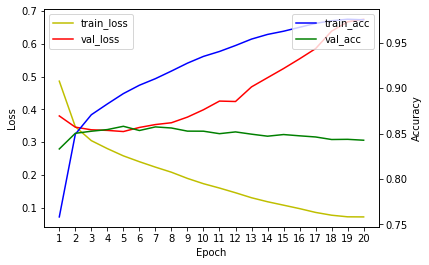

In [ ]:
acc_loss_plot(history)

In [ ]:
model=load_model('best_model.h5') # 가장 성능 좋은 모델 불러오기 (val_loss가 가장 작은 모델)
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.3389 - accuracy: 0.8564
[0.33893415331840515, 0.8563581705093384]
